In [211]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import geopandas as gpd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, classification_report #explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA #SparsePCA, NMF
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# from scipy.sparse import csr_matrix

## Find area of each city

In [25]:
venue_counts = pd.read_csv('data/counted_world_venues.csv', index_col=0)
venue_counts.set_index('City', drop=True, inplace=True)
venue_counts.fillna(0, inplace=True)
venue_counts = venue_counts.astype(int)
venue_counts

,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""","38""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
City,,,,,,,,,,,,,,,,,,,,,
Bangalore,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Tangerang,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Casablanca,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
Cairo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Phoenix,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Munich,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bogotá,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
Makasar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
venue_counts.insert(0, column='area_sqkm', value=None)
venue_counts

,area_sqkm,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
City,,,,,,,,,,,,,,,,,,,,,
Bangalore,None,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Tangerang,None,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Casablanca,None,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
Cairo,None,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Phoenix,None,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Munich,None,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bogotá,None,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
Makasar,None,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
for v in venue_counts.index:
    try:
        filename = re.sub('[^A-Za-z0-9]+', '', v)
        geo_df = gpd.read_file(f'data/foursquare_gridsearch/{filename}.geojson')
        geo_df_copy = geo_df.copy()
        geo_df_meters = geo_df_copy.to_crs({'init': 'epsg:3857'})
        area_sqkm = geo_df_meters.geometry.area[0]/10**6
        venue_counts.loc[v, 'area_sqkm'] = area_sqkm
    except:
        print('unable to find file for '+str(v))

Bangalore
Tangerang
Casablanca
Cairo
Phoenix
Esfahan
Fs
Aurangabad
Guangzhou
Fortaleza
HoChiMinhCity
Lima
Omsk
Prague
Madrid
Mashhad
Kyoto
Jersey
Singapore
Dallas
Tallinn
Adana
Dalian
Jakarta
Adelaide
Frankfurt
Tianjin
Wuhan
Almaty
Ulsan
Beijing
Fukuoka
SanAntonio
Lisbon
Stockholm
Kharkiv
Tegucigalpa
Patna
Philadelphia
Wien
Auckland
Baghdad
LosAngeles
Glasgow
Toluca
Belgrade
Lille
Moscow
Oslo
Shijiazhuang
Chennai
Lucknow
Harare
Ahwaz
Nanjing
Kobe
Guarulhos
BritishVirginIslands
Zhengzhou
Quanzhou
Xian
Dublin
KualaLumpur
SanDiego
SanFrancisco
Kawasaki
Tbilisi
Thane
Ekaterinburg
Zagreb
SantaCruz
Karachi
Luanda
London
LaLaguna
Lagos
Mumbai
Minsk
Mandalay
Montreal
Tokyo
Sydney
Birmingham
Jerusalem
Vienna
TelAviv
Nagoya
Qom
Guernsey
Perth
Harbin
Yerevan
Bahamas
Malta
Dsseldorf
Praha
Monterrey
MexicoCity
Bucharest
Chittagong
Daegu
Tabriz
Kolkata
Dhanbad
Konya
Shenyang
IsleofMan
Paris
Kazan
Ouagadougou
Baku
Ludhiana
Suzhou
Chongqing
Chicago
Hamburg
Athens
Hatay
SamutPrakan
Zurich
Amritsar
Riga

In [46]:
# Manually handle edge case
geo_df = gpd.read_file(f'data/foursquare_gridsearch/nyc.geojson')
geo_df_copy = geo_df.copy()
geo_df_meters = geo_df_copy.to_crs({'init': 'epsg:3857'})
area_sqkm = geo_df_meters.geometry.area[0]/10**6
venue_counts.loc['New York City', 'area_sqkm'] = area_sqkm
venue_counts

,area_sqkm,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
City,,,,,,,,,,,,,,,,,,,,,
Bangalore,753.052,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Tangerang,1049.89,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Casablanca,310.622,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
Cairo,4016.97,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Phoenix,1945.83,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Munich,697.59,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bogotá,630.268,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
Makasar,21.6597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Ensure all city areas written
venue_counts.area_sqkm.value_counts(dropna=False)

933.421726      2
1819.979438     2
1203.043524     2
697.589560      2
902.622912      2
               ..
554.035586      1
15678.789541    1
315.499020      1
826.119082      1
512.310746      1
Name: area_sqkm, Length: 245, dtype: int64

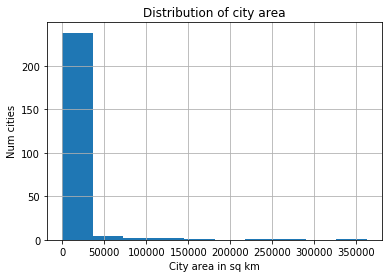

In [53]:
venue_counts.area_sqkm.hist()
plt.title('Distribution of city area')
plt.xlabel('City area in sq km')
plt.ylabel('Num cities')
plt.show()

In [62]:
venue_counts[venue_counts.area_sqkm.duplicated(keep=False)]

,area_sqkm,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
City,,,,,,,,,,,,,,,,,,,,,
Prague,1203.04,0,0,0,0,0,0,0,0,0,...,0,4,39,0,0,0,0,0,0,0
Wien,933.422,0,0,0,0,0,0,0,0,0,...,0,1,11,0,0,0,0,0,0,0
Montreal,902.623,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Vienna,933.422,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Praha,1203.04,0,0,0,0,0,0,0,0,0,...,0,4,44,0,0,0,0,0,0,0
Montréal,902.623,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
München,697.59,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nur-Sultan,1819.98,0,0,0,0,0,0,0,1,0,...,0,0,2,0,0,0,0,0,0,0
Astana,1819.98,0,0,0,0,0,0,0,1,0,...,0,0,2,0,0,0,0,0,0,0


In [73]:
# Handle duplicates - keep only city names in financial centres list
venue_counts.drop(['Wien', 'Montréal', 'München', 'Astana', 'Praha'], inplace=True)
venue_counts

,area_sqkm,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
City,,,,,,,,,,,,,,,,,,,,,
Bangalore,753.052,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Tangerang,1049.89,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Casablanca,310.622,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
Cairo,4016.97,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Phoenix,1945.83,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Munich,697.59,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bogotá,630.268,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
Makasar,21.6597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
venue_density = venue_counts.copy().iloc[:,1:].div(venue_counts.area_sqkm, axis=0)
venue_density = venue_density.astype(float)
venue_density

,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""","38""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
City,,,,,,,,,,,,,,,,,,,,,
Bangalore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.001328,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Tangerang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000952,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Casablanca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.003219,0.003219,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Cairo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Phoenix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.001542,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Munich,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Bogotá,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.003173,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Makasar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [122]:
venue_density.describe()

,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""","38""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,...,245.000000,245.000000,245.000000,245.000000,2.450000e+02,245.000000,245.000000,245.000000,245.000000,245.000000
mean,0.000001,0.000001,0.000002,0.000001,0.000001,0.000001,0.000001,0.000002,0.000001,0.000001,...,0.000051,0.000664,0.002095,0.000002,6.974633e-07,0.000003,0.000001,0.000001,0.000002,0.000001
std,0.000020,0.000020,0.000027,0.000020,0.000020,0.000020,0.000020,0.000035,0.000020,0.000020,...,0.000360,0.003047,0.008000,0.000028,6.439218e-06,0.000048,0.000020,0.000020,0.000027,0.000020
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000359,0.000515,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000308,0.000308,0.000424,0.000308,0.000308,0.000308,0.000308,0.000549,0.000308,0.000308,...,0.004176,0.043907,0.062462,0.000431,7.520831e-05,0.000754,0.000308,0.000308,0.000424,0.000308


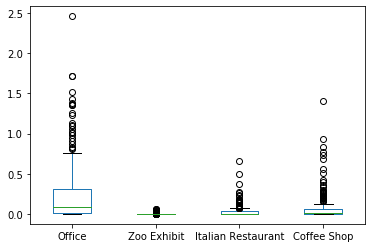

In [121]:
venue_density[['Office', 'Zoo Exhibit', 'Italian Restaurant', 'Coffee Shop']].plot(kind='box')

In [111]:
venue_density.mean().sort_values(ascending=False)

Office                                      2.489295e-01
Residential Building (Apartment / Condo)    1.984232e-01
Café                                        1.349419e-01
Building                                    1.308969e-01
Salon / Barbershop                          1.056610e-01
                                                ...     
Modern Greek Restaurant                     2.377285e-07
Imperial Restaurant                         1.903124e-07
 Otomotiv                                   1.897687e-07
Bangladeshi Restaurant                      1.625994e-07
 San Salvador"                              1.511943e-07
Length: 1011, dtype: float64

In [113]:
# from sklearn.feature_selection import VarianceThreshold

# # Create a VarianceThreshold feature selector
# sel = VarianceThreshold(threshold=0.001)

# # Fit the selector to normalized head_df
# sel.fit(head_df / head_df.mean())

# # Create a boolean mask
# mask = sel.get_support()

# # Apply the mask to create a reduced dataframe
# reduced_df = head_df.loc[:, mask]

In [114]:
venue_density.var().sort_values(ascending=False)

Residential Building (Apartment / Condo)    1.514155e-01
Office                                      1.477864e-01
Café                                        7.888650e-02
Indonesian Restaurant                       5.815394e-02
Building                                    5.354835e-02
                                                ...     
Cretan Restaurant                           1.213326e-11
Imperial Restaurant                         8.873609e-12
 Otomotiv                                   8.822976e-12
 San Salvador"                              5.600632e-12
Bangladeshi Restaurant                      3.268855e-12
Length: 1011, dtype: float64

In [123]:
corr = venue_density.corr()
corr

,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""","38""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
"Богданов и партнеры""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"""""dakineshop.ru""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"117""""""",-0.004098,-0.004098,1.000000,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,...,-0.009081,-0.013970,-0.016800,-0.004098,-0.006948,-0.004098,-0.004098,-0.004098,1.000000,-0.004098
"12""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"13""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Корпорация СБР""",-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,...,-0.009081,0.001896,-0.010757,-0.004098,-0.006948,1.000000,-0.004098,-0.004098,-0.004098,-0.004098
"д.24""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"не Дай Другим""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"площадка #2""",-0.004098,-0.004098,1.000000,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,...,-0.009081,-0.013970,-0.016800,-0.004098,-0.006948,-0.004098,-0.004098,-0.004098,1.000000,-0.004098


In [124]:
mask = np.triu(np.ones_like(corr, dtype=bool))
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])

In [125]:
corr[mask]

,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""","38""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
"Богданов и партнеры""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"Богданов и партнеры""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"Богданов и партнеры""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"Богданов и партнеры""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"Богданов и партнеры""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"не Дай Другим""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"не Дай Другим""""""",1.000000,1.000000,-0.004098,1.000000,1.000000,1.000000,1.000000,-0.004098,1.000000,1.000000,...,-0.009081,-0.007477,0.002983,-0.004098,-0.006948,-0.004098,1.000000,1.000000,-0.004098,1.000000
"площадка #2""",-0.004098,-0.004098,1.000000,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,...,-0.009081,-0.013970,-0.016800,-0.004098,-0.006948,-0.004098,-0.004098,-0.004098,1.000000,-0.004098
"площадка #2""",-0.004098,-0.004098,1.000000,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,-0.004098,...,-0.009081,-0.013970,-0.016800,-0.004098,-0.006948,-0.004098,-0.004098,-0.004098,1.000000,-0.004098


In [127]:
np.ones_like?

In [167]:
v['is_top_city'][0:5]

City
Bangalore     False
Tangerang     False
Casablanca     True
Cairo         False
Phoenix       False
Name: is_top_city, dtype: bool

In [175]:
train_test_split?

In [213]:
# Run PCA

X = venue_density
y = v['is_top_city']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3, stratify=y)

pipe = Pipeline([('scaler', StandardScaler()), ('reducer', PCA(n_components=0.9)), ('classifier', LogisticRegression(class_weight='balanced'))])
pipe.fit(X_train, y_train)
pipe

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reducer',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [214]:
y_pred = pipe.predict(X_test)

In [207]:
# pipe.score(X_train, y_test)

In [215]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.79      0.86        66
        True       0.26      0.62      0.37         8

    accuracy                           0.77        74
   macro avg       0.60      0.71      0.61        74
weighted avg       0.87      0.77      0.81        74



In [216]:
pd.DataFrame({'predicted': y_pred, 'true': y_test.values}).head(50)

,predicted,true
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,True,False
6,False,False
7,False,False
8,False,False
9,False,False


In [177]:
sns.scatterplot(pc[:,0], pc[:,1]) # hue=v['is_top_city'])
plt.title('First two pricipal components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

TypeError: unhashable type: 'slice'

In [172]:
len(pipe.steps[1][1].components_)

75

In [173]:
pipe.steps[2]

('classifier', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=None,
     shrinking=True, tol=0.001, verbose=False))

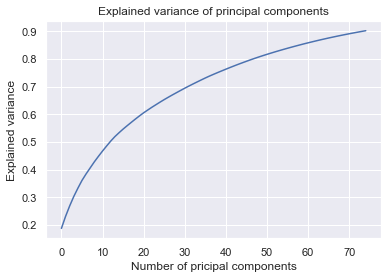

In [166]:
plt.plot(pipe.steps[1][1].explained_variance_ratio_.cumsum())
plt.title('Explained variance of principal components')
plt.xlabel('Number of pricipal components')
plt.ylabel('Explained variance')
plt.show()

In [136]:
ratings = pd.read_csv('data/cities_ratings.csv',index_col=0)
ratings.set_index('Centre', drop=True, inplace=True)
ratings

,Rating
Centre,
New York City,790
London,773
Hong Kong,771
Singapore,762
Shanghai,761
...,...
Athens,539
Dalian,529
Tianjin,528


In [146]:
v = venue_density.join(ratings) #,how='outer')

In [148]:
v['is_top_city'] = v.Rating>=700

In [59]:
# http://statweb.stanford.edu/~owen/reports/AOAS227.pdf
# Try using bi-cross validation (column + row holdout set)

In [ ]:
# https://towardsdatascience.com/how-to-use-cross-validation-for-matrix-completion-2b14103d2c4c
# 

In [ ]:
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) # create an array
# y = np.array([1, 2, 3, 4]) # Create another array
# kf = KFold(n_splits=2) # Define the split - into 2 folds 
# kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
# print(kf) 
# folds.get_n_splits()



In [12]:
# Try adding penalty terms (making it supervised)

In [ ]:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
